Deep Learning
=============

Here we attempt to load, explore and clean if required the data from street view housing numbers dataset. 

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from scipy import io
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import pandas as pd

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
def read_csv(filename):

    df = pd.read_csv(filename)
    df['LabelCount'] = df.DigitLabel
    df.DigitLabel = df['DigitLabel'].replace(10, 0)
    # right and bottom most offsets
    df['RightMost'] = df.Left + df.Width
    df['BottomMost'] = df.Top + df.Height

    grouped = df.groupby(['FileName'])
    agg = grouped.agg({'Left': np.min, 'Top': np.min, 'BottomMost': np.max, 'RightMost': np.max, 'LabelCount': np.size, 'DigitLabel': lambda x: tuple(x)})
    agg['Height'] = agg.BottomMost - agg.Top
    agg['Width'] = agg.RightMost - agg.Left
    return agg

In [3]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, csvData):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size, 3),
                         dtype=np.float32)
  # length and 5 digits - 10 to signify absence of a digit in sequence
  labels = np.ndarray(shape=(len(image_files), 6), dtype=np.int8)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      # first - label data
      label_data = csvData.loc[image]
      numbers = list(label_data.DigitLabel)
      # if length of the numbers is less than 5, pad it with 10s
      if len(numbers) < 5:
        numbers += [10]*(5-len(numbers))
      elif len(numbers) > 5:
        continue # skip this image. number of digits more than 5
      
      length = label_data.LabelCount-1 # lengths as labels from 0 to 4 where they are actually (1 to 5)
      labels[num_images, :] = np.array([length] + numbers)
    
      # now image data
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size, 3):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :, :] = image_data        
    
      # Increment the index counter
      num_images = num_images + 1
      
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :, :]
  labels = labels[0:num_images, :]
  
  print('Full dataset tensor:', dataset.shape)
  print('Full labels tensor:', labels.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return (dataset, labels)

train_dataset, train_labels = load_letter('train/proc/resized', read_csv('train/digitStruct.csv'))
test_dataset, test_labels = load_letter('test/proc/resized', read_csv('test/digitStruct.csv'))

train/proc/resized
Full dataset tensor: (33364, 32, 32, 3)
Full labels tensor: (33364, 6)
Mean: 0.0467986
Standard deviation: 0.239702
test/proc/resized
Full dataset tensor: (13060, 32, 32, 3)
Full labels tensor: (13060, 6)
Mean: 0.0297319
Standard deviation: 0.258086


[ 1  2  2 10 10 10]


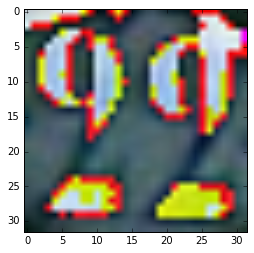

In [4]:
idx = 7
plt.imshow(train_dataset[idx])
print(train_labels[idx])

In [5]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [6]:
from sklearn.cross_validation import ShuffleSplit
kf = ShuffleSplit(train_labels.shape[0], random_state=0, train_size=0.9)
train_idx, valid_idx = next(iter(kf))
train_dataset_new = train_dataset[train_idx]
train_labels_new = train_labels[train_idx]
valid_dataset = train_dataset[valid_idx]
valid_labels = train_labels[valid_idx]
train_dataset = train_dataset_new
train_labels = train_labels_new
print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)
print(valid_dataset.shape)
print(valid_labels.shape)

(30027, 32, 32, 3)
(30027, 6)
(13060, 32, 32, 3)
(13060, 6)
(3337, 32, 32, 3)
(3337, 6)


In [7]:
pickle_file = 'SVHN_multi1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
max(train_labels[:, 5])

10